In [1]:
import os
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn

In [2]:
import sys; sys.path.append('..')
from data import *
from net import *

In [3]:
def train_model(model, optimizer, trainloader, valloader, criterion, device, save_path, num_epochs, verbose, dim=1):
    avg_train_loss, avg_val_loss = [], []
    top_1_acc, lowest_val_loss = 0, np.inf
    
    for e in range(num_epochs):
        t_loss, v_loss = [], []
        for x, y in trainloader:
            if dim == 1:
                x, y = x.unsqueeze(-1).float().to(device), y.long().to(device)
            elif dim == 2:
                x, y = x.float().to(device), y.long().to(device)
                
            pred = model(x)
            loss = criterion(pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            t_loss.append(loss.detach().cpu().numpy())
            
        acc_l = []
        for x, y in valloader:
            if dim == 1:
                x, y = x.unsqueeze(-1).float().to(device), y.long().to(device)
            elif dim == 2:
                x, y = x.float().to(device), y.long().to(device)
            
            pred = model(x)
            loss = criterion(pred, y)
            
            acc = sum(torch.argmax(F.softmax(pred, dim=1), dim=1) == y) / len(y)
            acc_l.append(acc.detach().cpu().numpy())
            v_loss.append(loss.detach().cpu().numpy())
            
        avg_train_loss.append(np.mean(t_loss))
        avg_val_loss.append(np.mean(v_loss))
        
        if np.mean(acc_l) > top_1_acc:
            top_1_acc = np.mean(acc_l)
        
        if np.mean(v_loss) < lowest_val_loss:
            lowest_val_loss = np.mean(v_loss)
            
            torch.save({
                'weights': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }, save_path)
        
        if e % verbose == 0:
            print(f'Epoch: {e}, Train Loss: {np.mean(avg_train_loss)}, Val Loss: {np.mean(avg_val_loss)}, Top 1 Acc: {top_1_acc}, Lowest Val Loss: {lowest_val_loss}')
        
    res = {
        'model': model,
        'optimizer': optimizer,
        'avg_train_loss': avg_train_loss,
        'avg_val_loss': avg_val_loss,
        'top_1_acc': top_1_acc,
        'lowest_val_loss': lowest_val_loss
    }
    
    return res

In [4]:
def prep_dosage_analysis(folder_path, train_csv_path, test_csv_path, dim=1):
    '''
    Returns a dictionary of items for training a classification model and performing analysis
    Trains on R1, test on R2
    '''
    if dim == 1:
        train_set = DosageDataset(folder_path, train_csv_path, remove_nans=True)
        test_set = DosageDataset(folder_path, test_csv_path, remove_nans=True)
    elif dim == 2:
        train_set = DosageDataset2D(folder_path, train_csv_path, remove_nans=True)
        test_set = DosageDataset2D(folder_path, train_csv_path, remove_nans=True)
    
    # create dataloaders
    t, v = int(len(train_set) * 0.9), int(len(train_set) * 0.1)
    while t + v != len(train_set):
        t += 1
    
    train, val = torch.utils.data.random_split(train_set, [t, v])
    trainloader = torch.utils.data.DataLoader(train, shuffle=True, batch_size=64)
    valloader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=64)
    
    return trainloader, valloader, test_set

In [5]:
def get_evaluation_metrics(model, test_set, device, target_names, dim=1):
    if dim == 1:
        tensor_data = torch.FloatTensor(test_set.data).unsqueeze(-1).to(device)
    elif dim == 2:
        tensor_data = torch.FloatTensor(test_set.data).to(device)
        
    pred = model(tensor_data)
    labels = test_set.labels
    
    np_pred = pred.detach().cpu().numpy()
    np_pred_labels = (torch.argmax(F.softmax(pred, dim=1), dim=1)).detach().cpu().numpy()
    
    acc = sum(np_pred_labels == labels) / len(labels)
    
    cr = sklearn.metrics.classification_report(labels, np_pred_labels, target_names=target_names)
    cm = sklearn.metrics.confusion_matrix(labels, np_pred_labels)
    cmd = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    
    res = {
        'acc': acc,
        'cr': cr,
        'cm': cm,
        'cmd': cmd
    }
    
    return res

In [43]:
def visualize_trajectories(dataset, dim=1, title=None):
    
    sep = []
    for i in range(len(dataset) - 1):
        if dataset.labels[i] != dataset.labels[i + 1]:
            sep.append(i + 1)
                
    if dim == 1:     
        trajectories = []
        trajectories.append(np.mean(dataset.data[0:sep[0]], axis=0))
        for i in range(len(sep) - 1):
            trajectory = np.mean(dataset.data[sep[i]:sep[i+1]], axis=0)
            trajectories.append(trajectory)
        trajectories.append(np.mean(dataset.data[sep[-1]:], axis=0))
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set(title=title)
        for dose, i in enumerate(trajectories):
            ax.plot(i, label='Dose ' + str(1 + dose))
            ax.legend()
            
        print(len(trajectories))
       
    
    elif dim == 2:
        trajectories_y, trajectories_z = [], []
        trajectories_y.append(np.mean(dataset.data[0:sep[0], :, 0], axis=0))
        trajectories_z.append(np.mean(dataset.data[0:sep[0], :, 1], axis=0))
        
        for i in range(len(sep) - 1):
            trajectory_y = np.mean(dataset.data[sep[i]:sep[i+1], :, 0], axis=0)
            trajectory_z = np.mean(dataset.data[sep[i]:sep[i+1], :, 1], axis=0)
            
            trajectories_y.append(trajectory_y)
            trajectories_z.append(trajectory_z)
            
        trajectories_y.append(np.mean(dataset.data[sep[-1]:, :, 0], axis=0))
        trajectories_z.append(np.mean(dataset.data[sep[-1]:, :, 1], axis=0))
        
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection='3d')
        ax.set(title=title)
        
        for dose, (i, j) in enumerate(zip(trajectories_y, trajectories_z)):
            ax.plot(
                xs = np.linspace(1, 95, 95),
                ys = i,
                zs = j,
                label = 'Dose ' + str(dose + 1)
            )
            ax.legend()

In [7]:
path = 'D:\\Data\\hoffmanlab\\lstmtimeseries\\data3\\'

In [8]:
target_names = ['Dose 1', 'Dose 2', 'Dose 3', 'Dose 4', 'Dose 5', 'Dose 6']

Model parameters: (self, input_dim, hidden_dim, output_dim, num_layers, linear_hidden_dim)

# CpG (1D & 2D)

In [34]:
cpg_ktr_train_path_1d = [i for i in os.listdir(path)[:6]]
cpg_ktr_test_path_1d = [i for i in os.listdir(path)[6:12]]

cpg_nfkb_train_path_1d = [i for i in os.listdir(path)[48:54]]
cpg_nfkb_test_path_1d = [i for i in os.listdir(path)[54:60]]

cpg_train_path_2d = [[i,j] for i,j in zip(cpg_ktr_train_path_1d, cpg_nfkb_train_path_1d)]
cpg_test_path_2d = [[i,j] for i,j in zip(cpg_ktr_test_path_1d, cpg_nfkb_test_path_1d)]

In [38]:
cpg_ktr_trainloader_1d, cpg_ktr_valloader_1d, cpg_ktr_testset_1d = prep_dosage_analysis(path, cpg_ktr_train_path_1d, cpg_ktr_test_path_1d, dim=1)
cpg_nfkb_trainloader_1d, cpg_nfkb_valloader_1d, cpg_nfkb_testset_1d = prep_dosage_analysis(path, cpg_nfkb_train_path_1d, cpg_nfkb_train_path_1d, dim=1)
cpg_trainloader_2d, cpg_valloader_2d, cpg_testset_2d = prep_dosage_analysis(path, cpg_train_path_2d, cpg_test_path_2d, dim=2)

### Data Vis

6


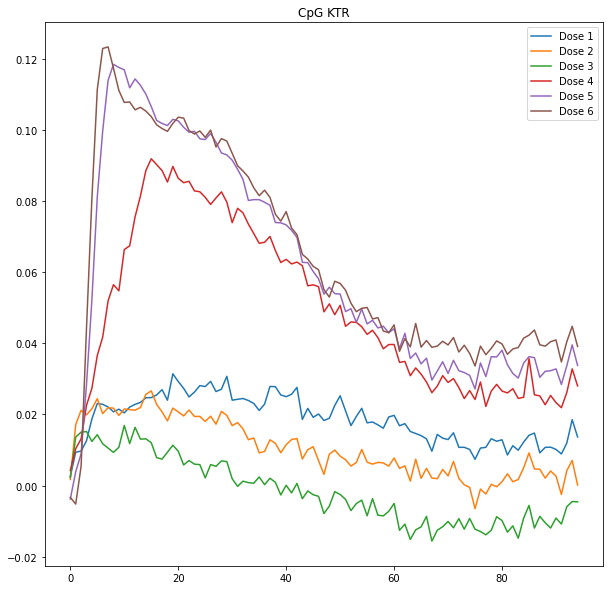

In [44]:
visualize_trajectories(cpg_ktr_testset_1d, dim=1, title='CpG KTR')

6


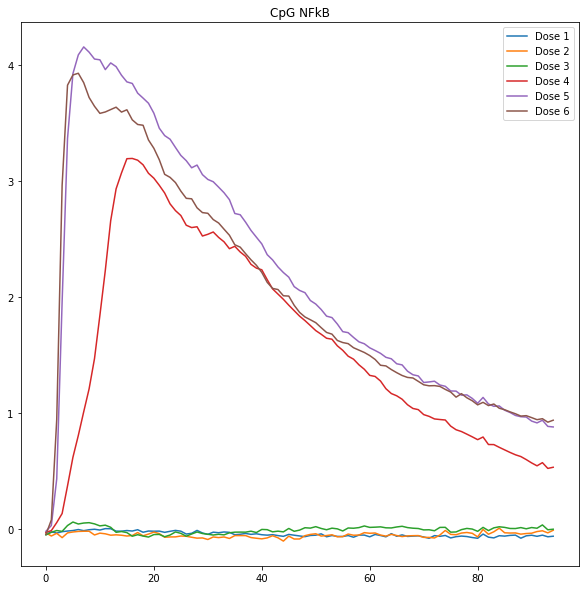

In [45]:
visualize_trajectories(cpg_nfkb_testset_1d, dim=1, title='CpG NFkB')

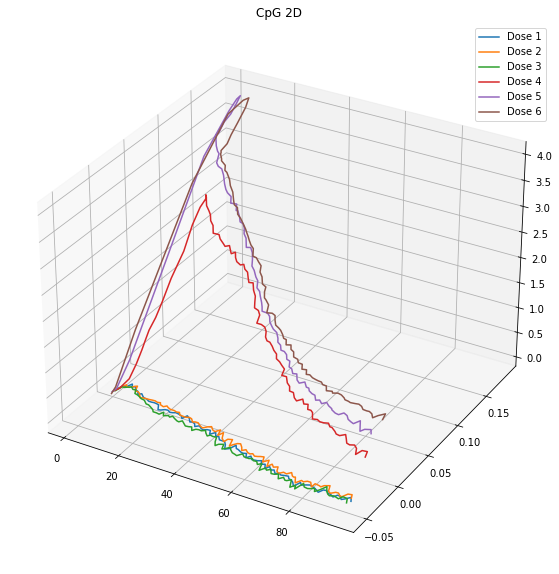

In [46]:
visualize_trajectories(cpg_testset_2d, dim=2, title='CpG 2D')

### 1D KTR

In [47]:
cpg_ktr_model = TSC_1(
    input_dim=1,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
cpg_ktr_model = cpg_ktr_model.to(device)
cpg_ktr_optim = torch.optim.Adam(cpg_ktr_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [48]:
res = train_model(
    model=cpg_ktr_model,
    optimizer=cpg_ktr_optim,
    trainloader=cpg_ktr_trainloader_1d,
    valloader=cpg_ktr_valloader_1d,
    criterion=criterion,
    device=device,
    save_path='../weights/cpg_ktr_dosage_best.pth',
    num_epochs=1500,
    dim=1,
    verbose=50
)

Epoch: 0, Train Loss: 1.7845077514648438, Val Loss: 1.7733525037765503, Top 1 Acc: 0.261284738779068, Lowest Val Loss: 1.7733525037765503
Epoch: 50, Train Loss: 1.7561737298965454, Val Loss: 1.745936632156372, Top 1 Acc: 0.3420138657093048, Lowest Val Loss: 1.5065892934799194
Epoch: 100, Train Loss: 1.539446234703064, Val Loss: 1.4996367692947388, Top 1 Acc: 0.4592014253139496, Lowest Val Loss: 1.1462249755859375
Epoch: 150, Train Loss: 1.4200124740600586, Val Loss: 1.3972560167312622, Top 1 Acc: 0.4704861342906952, Lowest Val Loss: 1.1007338762283325
Epoch: 200, Train Loss: 1.3513405323028564, Val Loss: 1.3421801328659058, Top 1 Acc: 0.4991319477558136, Lowest Val Loss: 1.1007338762283325
Epoch: 250, Train Loss: 1.3009021282196045, Val Loss: 1.3107504844665527, Top 1 Acc: 0.5112847685813904, Lowest Val Loss: 1.1007338762283325
Epoch: 300, Train Loss: 1.2575016021728516, Val Loss: 1.29433012008667, Top 1 Acc: 0.5112847685813904, Lowest Val Loss: 1.1007338762283325
Epoch: 350, Train Los

In [49]:
cpg_ktr_weights = torch.load('../weights/cpg_ktr_dosage_best.pth')
cpg_ktr_model.load_state_dict(cpg_ktr_weights['weights'])

<All keys matched successfully>

In [50]:
cpg_ktr_em = get_evaluation_metrics(cpg_ktr_model, cpg_ktr_testset_1d, device, target_names)

0.36328805294322536
              precision    recall  f1-score   support

      Dose 1       0.33      0.53      0.41       512
      Dose 2       0.23      0.09      0.13       366
      Dose 3       0.35      0.16      0.22       393
      Dose 4       0.33      0.66      0.44       461
      Dose 5       0.42      0.19      0.26       635
      Dose 6       0.49      0.50      0.50       504

    accuracy                           0.36      2871
   macro avg       0.36      0.35      0.32      2871
weighted avg       0.37      0.36      0.33      2871



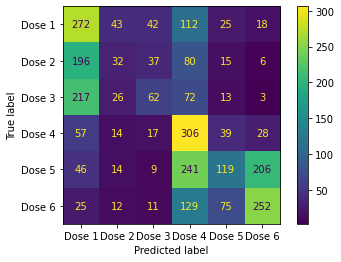

In [52]:
print(cpg_ktr_em['acc'])
print(cpg_ktr_em['cr'])
cpg_ktr_em['cmd'].plot()

### 1D NFkB

In [53]:
cpg_nfkb_model = TSC_1(
    input_dim=1,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
cpg_nfkb_model = cpg_nfkb_model.to(device)
cpg_nfkb_optim = torch.optim.Adam(cpg_nfkb_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [54]:
res = train_model(
    model=cpg_nfkb_model,
    optimizer=cpg_nfkb_optim,
    trainloader=cpg_nfkb_trainloader_1d,
    valloader=cpg_nfkb_valloader_1d,
    criterion=criterion,
    device=device,
    save_path='../weights/cpg_nfkb_dosage_best.pth',
    num_epochs=750,
    dim=1,
    verbose=50
)

Epoch: 0, Train Loss: 1.529042363166809, Val Loss: 1.3684377670288086, Top 1 Acc: 0.33733975887298584, Lowest Val Loss: 1.3684377670288086
Epoch: 50, Train Loss: 1.2891340255737305, Val Loss: 1.2626653909683228, Top 1 Acc: 0.5064103007316589, Lowest Val Loss: 1.0739740133285522
Epoch: 100, Train Loss: 1.1408427953720093, Val Loss: 1.1045984029769897, Top 1 Acc: 0.6284054517745972, Lowest Val Loss: 0.8513452410697937
Epoch: 150, Train Loss: 1.0561540126800537, Val Loss: 1.0213559865951538, Top 1 Acc: 0.6540464758872986, Lowest Val Loss: 0.790381669998169
Epoch: 200, Train Loss: 0.9993070363998413, Val Loss: 0.971360445022583, Top 1 Acc: 0.6616587042808533, Lowest Val Loss: 0.7633643746376038
Epoch: 250, Train Loss: 0.9538230299949646, Val Loss: 0.9427136182785034, Top 1 Acc: 0.6616587042808533, Lowest Val Loss: 0.7542853951454163
Epoch: 300, Train Loss: 0.9197484850883484, Val Loss: 0.9292995929718018, Top 1 Acc: 0.6616587042808533, Lowest Val Loss: 0.7542853951454163
Epoch: 350, Train 

In [55]:
cpg_nfkb_weights = torch.load('../weights/cpg_nfkb_dosage_best.pth')
cpg_nfkb_model.load_state_dict(cpg_nfkb_weights['weights'])

<All keys matched successfully>

In [56]:
cpg_nfkb_em = get_evaluation_metrics(cpg_nfkb_model, cpg_nfkb_testset_1d, device, target_names)

0.6217430368373764
              precision    recall  f1-score   support

      Dose 1       0.42      0.87      0.56       576
      Dose 2       0.60      0.06      0.11       430
      Dose 3       0.40      0.22      0.29       489
      Dose 4       0.95      0.90      0.92       597
      Dose 5       0.66      0.72      0.69       603
      Dose 6       0.78      0.73      0.75       644

    accuracy                           0.62      3339
   macro avg       0.63      0.58      0.55      3339
weighted avg       0.65      0.62      0.59      3339



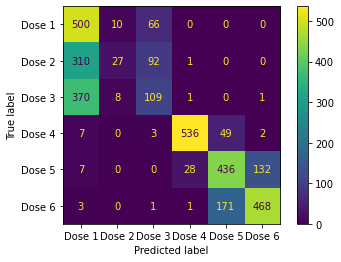

In [57]:
print(cpg_nfkb_em['acc'])
print(cpg_nfkb_em['cr'])
cpg_nfkb_em['cmd'].plot()

## 2D

In [58]:
cpg_2d_model = TSC_1(
    input_dim=2,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
cpg_2d_model = cpg_2d_model.to(device)
cpg_2d_optim = torch.optim.Adam(cpg_2d_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [61]:
res = train_model(
    model=cpg_2d_model,
    optimizer=cpg_2d_optim,
    trainloader=cpg_trainloader_2d,
    valloader=cpg_valloader_2d,
    criterion=criterion,
    device=device,
    save_path='../weights/cpg_2d_dosage_best.pth',
    num_epochs=750,
    dim=2,
    verbose=50
)

Epoch: 0, Train Loss: 1.134450912475586, Val Loss: 1.2264515161514282, Top 1 Acc: 0.4670139253139496, Lowest Val Loss: 1.2264515161514282
Epoch: 50, Train Loss: 1.1307775974273682, Val Loss: 1.1724005937576294, Top 1 Acc: 0.5546875, Lowest Val Loss: 1.003646731376648
Epoch: 100, Train Loss: 1.057898759841919, Val Loss: 1.0862935781478882, Top 1 Acc: 0.6284722685813904, Lowest Val Loss: 0.8667573928833008
Epoch: 150, Train Loss: 0.9989526867866516, Val Loss: 1.0253263711929321, Top 1 Acc: 0.6284722685813904, Lowest Val Loss: 0.8379673361778259
Epoch: 200, Train Loss: 0.9579555988311768, Val Loss: 0.9872145056724548, Top 1 Acc: 0.6640625, Lowest Val Loss: 0.7972478866577148
Epoch: 250, Train Loss: 0.9252904653549194, Val Loss: 0.9597017765045166, Top 1 Acc: 0.6649305820465088, Lowest Val Loss: 0.7853153347969055
Epoch: 300, Train Loss: 0.8961761593818665, Val Loss: 0.9457408785820007, Top 1 Acc: 0.6649305820465088, Lowest Val Loss: 0.7853153347969055
Epoch: 350, Train Loss: 0.87288385629

In [62]:
cpg_2d_weights = torch.load('../weights/cpg_2d_dosage_best.pth')
cpg_2d_model.load_state_dict(cpg_2d_weights['weights'])

<All keys matched successfully>

In [65]:
cpg_2d_em = get_evaluation_metrics(cpg_2d_model, cpg_testset_2d, device, target_names, dim=2)

0.6161251504211793
              precision    recall  f1-score   support

      Dose 1       0.45      0.83      0.58       574
      Dose 2       0.47      0.19      0.27       428
      Dose 3       0.42      0.22      0.29       486
      Dose 4       0.88      0.85      0.87       593
      Dose 5       0.63      0.79      0.70       601
      Dose 6       0.82      0.62      0.71       642

    accuracy                           0.62      3324
   macro avg       0.61      0.59      0.57      3324
weighted avg       0.63      0.62      0.60      3324



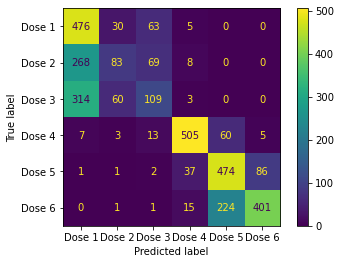

In [66]:
print(cpg_2d_em['acc'])
print(cpg_2d_em['cr'])
cpg_2d_em['cmd'].plot()

# LPS (1D & 2D)

## Data Vis

In [67]:
lps_nfkb_train_path = os.listdir(path)[60:66]
lps_nfkb_test_path = os.listdir(path)[66:72]

lps_nfkb_trainloader, lps_nfkb_valloader, lps_nfkb_testset = prep_dosage_analysis(path, lps_nfkb_train_path, lps_nfkb_test_path)

6


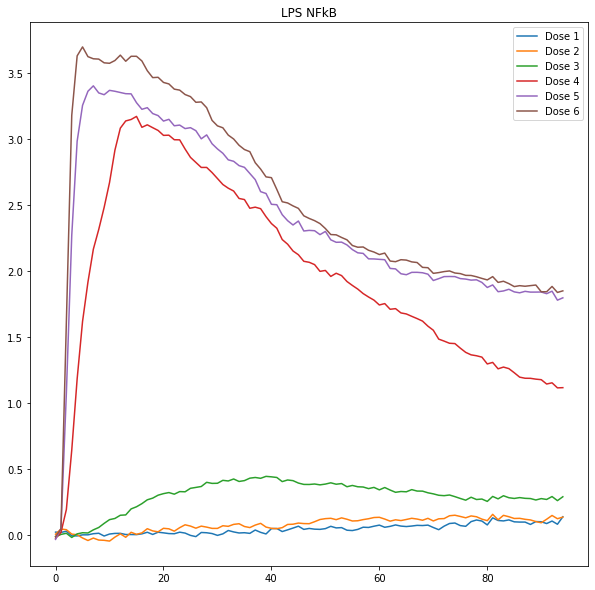

In [68]:
visualize_trajectories(lps_nfkb_testset, dim=1, title='LPS NFkB')

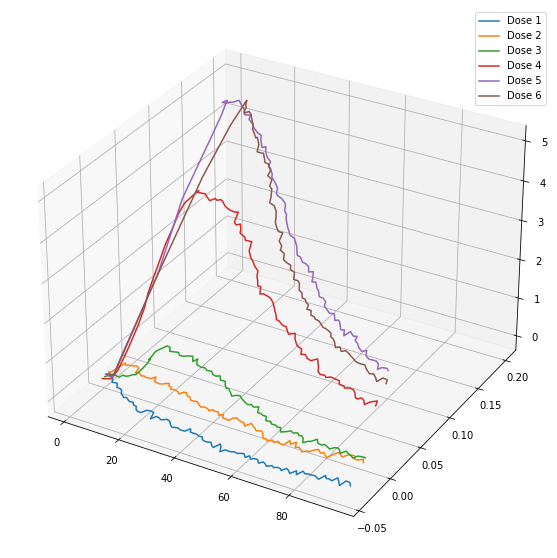

In [150]:
visualize_trajectories(testset_lps_2d, dim=2)

## 1D KTR

In [17]:
lps_train = os.listdir(path)[12:18]
lps_test = os.listdir(path)[18:24]

In [18]:
trainloader, valloader, test_set = prep_dosage_analysis(path, lps_train, lps_test, dim=1)

In [41]:
lps_model = TSC_1(
    input_dim=1,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
lps_model = lps_model.to(device)
lps_optim = torch.optim.Adam(lps_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [43]:
res = train_model(
    model=lps_model,
    optimizer=lps_optim,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    device=device,
    save_path='../weights/lps_1d_dosage_best.pth',
    num_epochs=1500,
    dim=1,
    verbose=50
)

Epoch: 0, Train Loss: 1.7870389223098755, Val Loss: 1.794515609741211, Top 1 Acc: 0.24291324615478516, Lowest Val Loss: 1.794515609741211
Epoch: 50, Train Loss: 1.6800429821014404, Val Loss: 1.6894395351409912, Top 1 Acc: 0.3803790807723999, Lowest Val Loss: 1.539050579071045
Epoch: 100, Train Loss: 1.720321774482727, Val Loss: 1.7274754047393799, Top 1 Acc: 0.3803790807723999, Lowest Val Loss: 1.539050579071045
Epoch: 150, Train Loss: 1.6962144374847412, Val Loss: 1.7071044445037842, Top 1 Acc: 0.3803790807723999, Lowest Val Loss: 1.539050579071045
Epoch: 200, Train Loss: 1.7067567110061646, Val Loss: 1.7181168794631958, Top 1 Acc: 0.4017247259616852, Lowest Val Loss: 1.508217215538025
Epoch: 250, Train Loss: 1.666322946548462, Val Loss: 1.6817959547042847, Top 1 Acc: 0.45432034134864807, Lowest Val Loss: 1.3366180658340454
Epoch: 300, Train Loss: 1.597885012626648, Val Loss: 1.6231954097747803, Top 1 Acc: 0.4938524663448334, Lowest Val Loss: 1.2830578088760376
Epoch: 350, Train Loss:

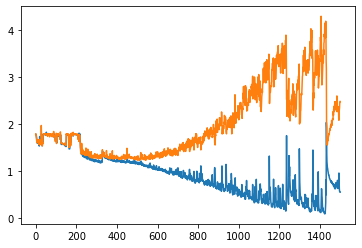

In [44]:
plt.plot(res['avg_train_loss'])
plt.plot(res['avg_val_loss'])

In [47]:
lps_weights = torch.load('../weights/lps_1d_dosage_best.pth')
lps_model.load_state_dict(lps_weights['weights'])

<All keys matched successfully>

In [57]:
x = get_evaluation_metrics(lps_model, test_set, device, target_names)

0.40364842454394695
              precision    recall  f1-score   support

      Dose 1       0.20      0.18      0.19       412
      Dose 2       0.26      0.37      0.31       426
      Dose 3       0.32      0.28      0.30       527
      Dose 4       0.54      0.60      0.57       518
      Dose 5       0.50      0.25      0.34       560
      Dose 6       0.53      0.67      0.59       572

    accuracy                           0.40      3015
   macro avg       0.39      0.39      0.38      3015
weighted avg       0.41      0.40      0.39      3015



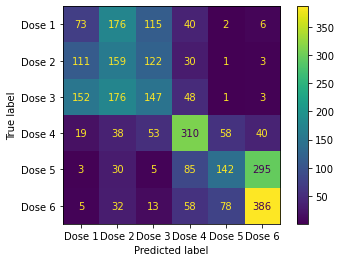

In [60]:
print(x['acc'])
print(x['cr'])
x['cmd'].plot()

### 1D NFkB

In [69]:
lps_nfkb_model = TSC_1(
    input_dim=1,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
lps_nfkb_model = lps_nfkb_model.to(device)
lps_nfkb_optim = torch.optim.Adam(lps_nfkb_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [70]:
res = train_model(
    model=lps_nfkb_model,
    optimizer=lps_nfkb_optim,
    trainloader=lps_nfkb_trainloader,
    valloader=lps_nfkb_valloader,
    criterion=criterion,
    device=device,
    save_path='../weights/lps_nfkb_dosage_best.pth',
    num_epochs=1500,
    dim=1,
    verbose=50
)

Epoch: 0, Train Loss: 1.6239603757858276, Val Loss: 1.522343635559082, Top 1 Acc: 0.3394808769226074, Lowest Val Loss: 1.522343635559082
Epoch: 50, Train Loss: 1.2574965953826904, Val Loss: 1.2894827127456665, Top 1 Acc: 0.5029883980751038, Lowest Val Loss: 1.1801080703735352
Epoch: 100, Train Loss: 1.1480884552001953, Val Loss: 1.2227122783660889, Top 1 Acc: 0.5654883980751038, Lowest Val Loss: 1.065510869026184
Epoch: 150, Train Loss: 1.068185567855835, Val Loss: 1.185166835784912, Top 1 Acc: 0.5883708596229553, Lowest Val Loss: 1.0481408834457397
Epoch: 200, Train Loss: 1.0196897983551025, Val Loss: 1.1590622663497925, Top 1 Acc: 0.6193647384643555, Lowest Val Loss: 1.028993844985962
Epoch: 250, Train Loss: 0.9726639986038208, Val Loss: 1.1496690511703491, Top 1 Acc: 0.6292691230773926, Lowest Val Loss: 1.028993844985962
Epoch: 300, Train Loss: 0.9316577315330505, Val Loss: 1.1558629274368286, Top 1 Acc: 0.6292691230773926, Lowest Val Loss: 1.028993844985962
Epoch: 350, Train Loss: 

In [71]:
lps_nfkb_weights = torch.load('../weights/lps_nfkb_dosage_best.pth')
lps_nfkb_model.load_state_dict(lps_nfkb_weights['weights'])

<All keys matched successfully>

In [72]:
lps_nfkb_em = get_evaluation_metrics(lps_nfkb_model, lps_nfkb_testset, device, target_names, dim=1)

0.46050032916392364
              precision    recall  f1-score   support

      Dose 1       0.41      0.18      0.25       414
      Dose 2       0.31      0.70      0.43       430
      Dose 3       0.53      0.28      0.37       529
      Dose 4       0.75      0.60      0.67       522
      Dose 5       0.51      0.03      0.06       567
      Dose 6       0.46      0.94      0.62       576

    accuracy                           0.46      3038
   macro avg       0.50      0.46      0.40      3038
weighted avg       0.51      0.46      0.40      3038



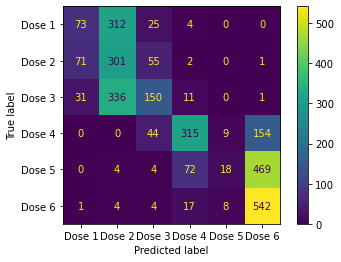

In [73]:
print(lps_nfkb_em['acc'])
print(lps_nfkb_em['cr'])
lps_nfkb_em['cmd'].plot()

# 2D

In [67]:
lps_train_2d = [[i, j] for i, j in zip(os.listdir(path)[12:18], os.listdir(path)[60:66])]

In [69]:
lps_test_2d = [[i, j] for i, j in zip(os.listdir(path)[18:24], os.listdir(path)[66:72])]

In [74]:
trainloader_lps_2d, valloader_lps_2d, testset_lps_2d = prep_dosage_analysis(path, lps_train_2d, lps_test_2d, dim=2)

In [86]:
lps_model_2d = TSC_1(
    input_dim=2,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
lps_model_2d = lps_model_2d.to(device)
lps_optim_2d = torch.optim.Adam(lps_model_2d.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [87]:
lps_2d_res = train_model(
    model=lps_model_2d,
    optimizer=lps_optim_2d,
    trainloader=trainloader_lps_2d,
    valloader=valloader_lps_2d,
    criterion=criterion,
    device=device,
    save_path='../weights/lps_2d_dosage_best.pth',
    num_epochs=750,
    dim=2,
    verbose=50
)

Epoch: 0, Train Loss: 1.6140695810317993, Val Loss: 1.5558509826660156, Top 1 Acc: 0.3295764923095703, Lowest Val Loss: 1.5558509826660156
Epoch: 50, Train Loss: 1.2501360177993774, Val Loss: 1.292904019355774, Top 1 Acc: 0.49829235672950745, Lowest Val Loss: 1.1311548948287964
Epoch: 100, Train Loss: 1.3242920637130737, Val Loss: 1.3756351470947266, Top 1 Acc: 0.5181010961532593, Lowest Val Loss: 1.1311548948287964
Epoch: 150, Train Loss: 1.2664893865585327, Val Loss: 1.316710352897644, Top 1 Acc: 0.539702832698822, Lowest Val Loss: 1.0904775857925415
Epoch: 200, Train Loss: 1.192568063735962, Val Loss: 1.253199815750122, Top 1 Acc: 0.6511270403862, Lowest Val Loss: 0.9861283302307129
Epoch: 250, Train Loss: 1.1304943561553955, Val Loss: 1.2023100852966309, Top 1 Acc: 0.6511270403862, Lowest Val Loss: 0.9403747916221619
Epoch: 300, Train Loss: 1.0760695934295654, Val Loss: 1.1658148765563965, Top 1 Acc: 0.6709358096122742, Lowest Val Loss: 0.9287316203117371
Epoch: 350, Train Loss: 1.

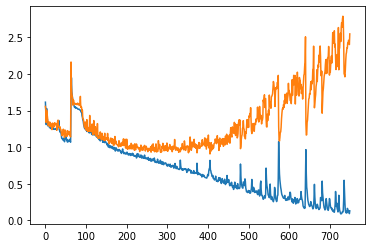

In [88]:
plt.plot(lps_2d_res['avg_train_loss'])
plt.plot(lps_2d_res['avg_val_loss'])

In [89]:
lps_model_2d_weights = torch.load('../weights/lps_2d_dosage_best.pth')
lps_model_2d.load_state_dict(lps_model_2d_weights['weights'])

<All keys matched successfully>

In [91]:
lps_2d_em = get_evaluation_metrics(lps_model_2d, testset_lps_2d, device, target_names, dim=2)

0.6883597883597884
              precision    recall  f1-score   support

      Dose 1       0.54      0.56      0.55       276
      Dose 2       0.62      0.60      0.61       363
      Dose 3       0.70      0.67      0.69       288
      Dose 4       0.82      0.79      0.80       319
      Dose 5       0.59      0.80      0.68       265
      Dose 6       0.87      0.72      0.79       379

    accuracy                           0.69      1890
   macro avg       0.69      0.69      0.69      1890
weighted avg       0.70      0.69      0.69      1890



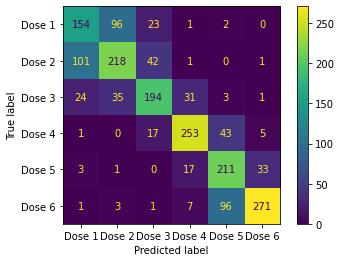

In [92]:
print(lps_2d_em['acc'])
print(lps_2d_em['cr'])
lps_2d_em['cmd'].plot()

# P3C4

In [152]:
p3c4_1d_train_path = os.listdir(path)[24:30]
p3c4_1d_test_path = os.listdir(path)[30:36]

In [156]:
p3c4_2d_train_path = [[i, j] for i,j in zip(os.listdir(path)[24:30], os.listdir(path)[72:80])]
p3c4_2d_test_path = [[i, j] for i,j in zip(os.listdir(path)[30:36], os.listdir(path)[78:84])]

In [154]:
trainloader_1d_p3c4, valloader_1d_p3c4, testset_1d_p3c4 = prep_dosage_analysis(path, p3c4_1d_train_path, p3c4_1d_test_path)

In [161]:
trainloader_2d_p3c4, valloader_2d_p3c4, testset_2d_p3c4 = prep_dosage_analysis(path, p3c4_2d_train_path, p3c4_2d_test_path, dim=2)

In [74]:
p3c4_nfkb_train_path = os.listdir(path)[72:78]
p3c4_nfkb_test_path = os.listdir(path)[78:84]

In [75]:
p3c4_nfkb_trainloader, p3c4_nfkb_valloader, p3c4_nfkb_testset = prep_dosage_analysis(path, p3c4_nfkb_train_path, p3c4_nfkb_test_path, dim=1)

## Data Vis

6


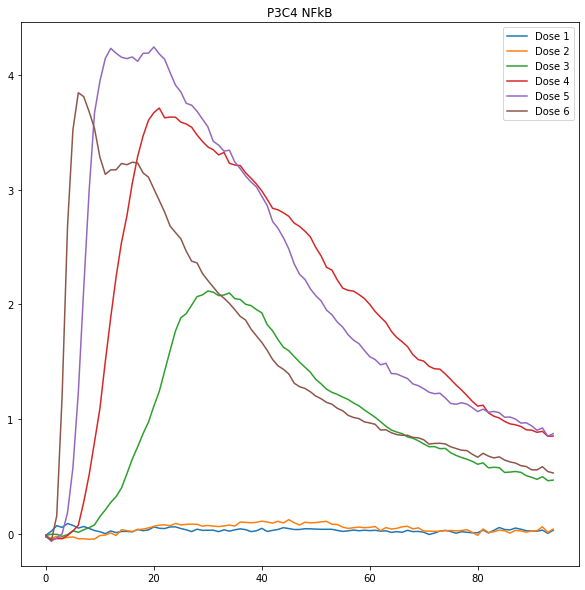

In [78]:
visualize_trajectories(p3c4_nfkb_testset, title='P3C4 NFkB')

6


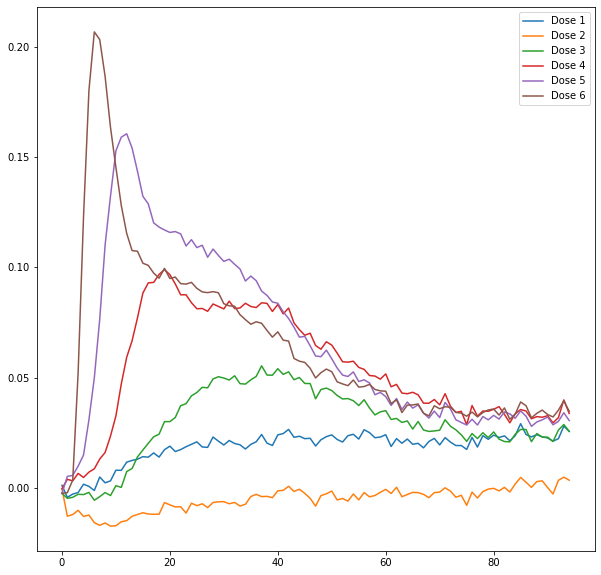

In [162]:
visualize_trajectories(testset_1d_p3c4)

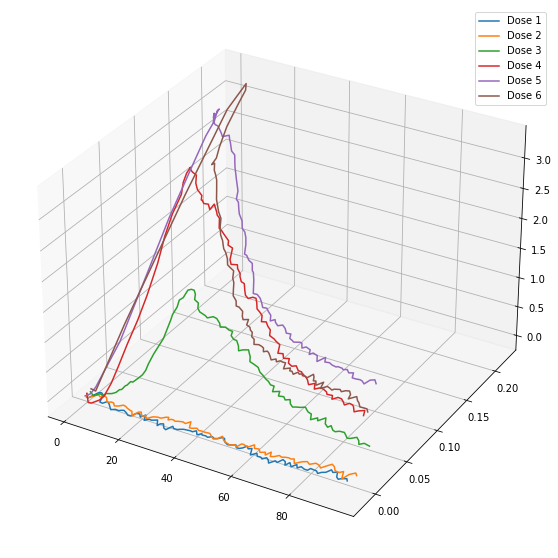

In [163]:
visualize_trajectories(testset_2d_p3c4, dim=2)

### 1D KTR

In [164]:
p3c4_model_1d = TSC_1(
    input_dim=1,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
p3c4_model_1d = p3c4_model_1d.to(device)
p3c4_optim_1d = torch.optim.Adam(p3c4_model_1d.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [166]:
res = train_model(
    model=p3c4_model_1d,
    optimizer=p3c4_optim_1d,
    trainloader=trainloader_1d_p3c4,
    valloader=valloader_1d_p3c4,
    criterion=criterion,
    device=device,
    save_path='../weights/p3c4_1d_dosage_best.pth',
    num_epochs=1500,
    dim=1,
    verbose=50
)

Epoch: 0, Train Loss: 1.7945514917373657, Val Loss: 1.7912145853042603, Top 1 Acc: 0.16779513657093048, Lowest Val Loss: 1.7912145853042603
Epoch: 50, Train Loss: 1.7837564945220947, Val Loss: 1.7763400077819824, Top 1 Acc: 0.2469618022441864, Lowest Val Loss: 1.7127989530563354
Epoch: 100, Train Loss: 1.7820087671279907, Val Loss: 1.7789777517318726, Top 1 Acc: 0.2469618022441864, Lowest Val Loss: 1.6917439699172974
Epoch: 150, Train Loss: 1.7396862506866455, Val Loss: 1.740587830543518, Top 1 Acc: 0.42135417461395264, Lowest Val Loss: 1.3789528608322144
Epoch: 200, Train Loss: 1.644813060760498, Val Loss: 1.646895408630371, Top 1 Acc: 0.4743923544883728, Lowest Val Loss: 1.2033932209014893
Epoch: 250, Train Loss: 1.5629850625991821, Val Loss: 1.5619521141052246, Top 1 Acc: 0.5295138955116272, Lowest Val Loss: 1.143491506576538
Epoch: 300, Train Loss: 1.503106713294983, Val Loss: 1.5014431476593018, Top 1 Acc: 0.5295138955116272, Lowest Val Loss: 1.1357941627502441
Epoch: 350, Train L

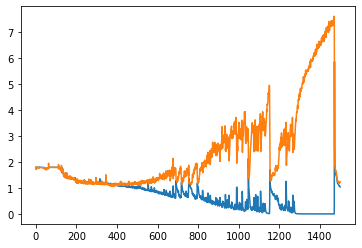

In [167]:
plt.plot(res['avg_train_loss'])
plt.plot(res['avg_val_loss'])

In [168]:
p3c4_weights_1d = torch.load('../weights/p3c4_1d_dosage_best.pth')
p3c4_model_1d.load_state_dict(p3c4_weights_1d['weights'])

<All keys matched successfully>

In [171]:
p3c4_em_1d = get_evaluation_metrics(p3c4_model_1d, testset_1d_p3c4, device, target_names, dim=1)

0.49536850583971004
              precision    recall  f1-score   support

      Dose 1       0.36      0.09      0.15       464
      Dose 2       0.37      0.68      0.48       401
      Dose 3       0.39      0.41      0.40       431
      Dose 4       0.49      0.56      0.52       365
      Dose 5       0.52      0.65      0.58       345
      Dose 6       0.93      0.65      0.77       477

    accuracy                           0.50      2483
   macro avg       0.51      0.51      0.48      2483
weighted avg       0.52      0.50      0.48      2483



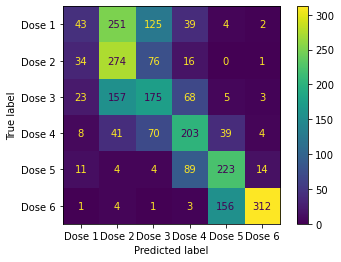

In [172]:
print(p3c4_em_1d['acc'])
print(p3c4_em_1d['cr'])
p3c4_em_1d['cmd'].plot()

### NFkB 1D

In [79]:
p3c4_nfkb_model = TSC_1(
    input_dim=1,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
p3c4_nfkb_model = p3c4_nfkb_model.to(device)
p3c4_nfkb_optim = torch.optim.Adam(p3c4_nfkb_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [81]:
res = train_model(
    model=p3c4_nfkb_model,
    optimizer=p3c4_nfkb_optim,
    trainloader=p3c4_nfkb_trainloader,
    valloader=p3c4_nfkb_valloader,
    criterion=criterion,
    device=device,
    save_path='../weights/p3c4_nfkb_dosage_best.pth',
    num_epochs=1500,
    dim=1,
    verbose=50
)

Epoch: 0, Train Loss: 1.696408987045288, Val Loss: 1.6490658521652222, Top 1 Acc: 0.234375, Lowest Val Loss: 1.6490658521652222
Epoch: 50, Train Loss: 1.5773217678070068, Val Loss: 1.5603574514389038, Top 1 Acc: 0.4322916865348816, Lowest Val Loss: 1.3400237560272217
Epoch: 100, Train Loss: 1.471530556678772, Val Loss: 1.4440562725067139, Top 1 Acc: 0.4401041865348816, Lowest Val Loss: 1.183432698249817
Epoch: 150, Train Loss: 1.2983853816986084, Val Loss: 1.2658363580703735, Top 1 Acc: 0.6653646230697632, Lowest Val Loss: 0.7295461893081665
Epoch: 200, Train Loss: 1.1582531929016113, Val Loss: 1.1406548023223877, Top 1 Acc: 0.6888021230697632, Lowest Val Loss: 0.7071433067321777
Epoch: 250, Train Loss: 1.0620750188827515, Val Loss: 1.074564814567566, Top 1 Acc: 0.6888021230697632, Lowest Val Loss: 0.7071433067321777
Epoch: 300, Train Loss: 0.9814856648445129, Val Loss: 1.0422253608703613, Top 1 Acc: 0.6888021230697632, Lowest Val Loss: 0.7071433067321777
Epoch: 350, Train Loss: 0.9637

In [82]:
p3c4_nfkb_weights = torch.load('../weights/p3c4_nfkb_dosage_best.pth')
p3c4_nfkb_model.load_state_dict(p3c4_nfkb_weights['weights'])

<All keys matched successfully>

In [83]:
p3c4_nfkb_em = get_evaluation_metrics(p3c4_nfkb_model, p3c4_nfkb_testset, device, target_names, dim=1)

0.5911646586345382
              precision    recall  f1-score   support

      Dose 1       0.61      0.53      0.56       466
      Dose 2       0.46      0.51      0.49       401
      Dose 3       0.65      0.80      0.72       434
      Dose 4       0.50      0.56      0.53       366
      Dose 5       0.46      0.53      0.50       346
      Dose 6       0.97      0.59      0.73       477

    accuracy                           0.59      2490
   macro avg       0.61      0.59      0.59      2490
weighted avg       0.62      0.59      0.60      2490



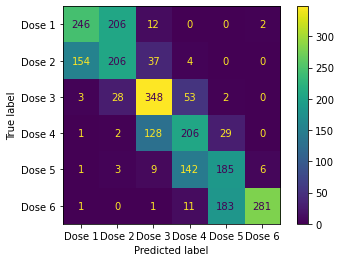

In [84]:
print(p3c4_nfkb_em['acc'])
print(p3c4_nfkb_em['cr'])
p3c4_nfkb_em['cmd'].plot()

## 2D

In [173]:
p3c4_model_2d = TSC_1(
    input_dim=2,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
p3c4_model_2d = p3c4_model_2d.to(device)
p3c4_optim_2d = torch.optim.Adam(p3c4_model_2d.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [174]:
res = train_model(
    model=p3c4_model_2d,
    optimizer=p3c4_optim_2d,
    trainloader=trainloader_2d_p3c4,
    valloader=valloader_2d_p3c4,
    criterion=criterion,
    device=device,
    save_path='../weights/p3c4_2d_dosage_best.pth',
    num_epochs=750,
    dim=2,
    verbose=50
)

Epoch: 0, Train Loss: 1.6925644874572754, Val Loss: 1.6256587505340576, Top 1 Acc: 0.26484376192092896, Lowest Val Loss: 1.6256587505340576
Epoch: 50, Train Loss: 1.4602537155151367, Val Loss: 1.4429017305374146, Top 1 Acc: 0.5122395753860474, Lowest Val Loss: 1.1447057723999023
Epoch: 100, Train Loss: 1.2174686193466187, Val Loss: 1.2037485837936401, Top 1 Acc: 0.664843738079071, Lowest Val Loss: 0.7522091269493103
Epoch: 150, Train Loss: 1.071087121963501, Val Loss: 1.0663974285125732, Top 1 Acc: 0.6878472566604614, Lowest Val Loss: 0.7402246594429016
Epoch: 200, Train Loss: 0.9869018793106079, Val Loss: 0.9900989532470703, Top 1 Acc: 0.6894965171813965, Lowest Val Loss: 0.7130985856056213
Epoch: 250, Train Loss: 0.93115234375, Val Loss: 0.9421109557151794, Top 1 Acc: 0.6894965171813965, Lowest Val Loss: 0.7050255537033081
Epoch: 300, Train Loss: 0.8872789144515991, Val Loss: 0.9140532612800598, Top 1 Acc: 0.6894965171813965, Lowest Val Loss: 0.7050255537033081
Epoch: 350, Train Loss

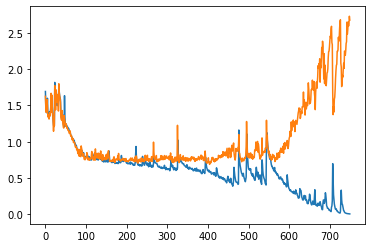

In [175]:
plt.plot(res['avg_train_loss'])
plt.plot(res['avg_val_loss'])

In [176]:
p3c4_weights_2d = torch.load('../weights/p3c4_2d_dosage_best.pth')
p3c4_model_2d.load_state_dict(p3c4_weights_2d['weights'])

<All keys matched successfully>

In [177]:
p3c4_em_2d = get_evaluation_metrics(p3c4_model_2d, testset_2d_p3c4, device, target_names, dim=2)

0.7312236286919831
              precision    recall  f1-score   support

      Dose 1       0.60      0.60      0.60       384
      Dose 2       0.57      0.59      0.58       403
      Dose 3       0.88      0.76      0.82       365
      Dose 4       0.77      0.85      0.81       406
      Dose 5       0.74      0.73      0.73       410
      Dose 6       0.86      0.84      0.85       402

    accuracy                           0.73      2370
   macro avg       0.74      0.73      0.73      2370
weighted avg       0.74      0.73      0.73      2370



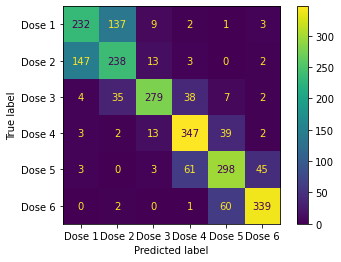

In [178]:
print(p3c4_em_2d['acc'])
print(p3c4_em_2d['cr'])
p3c4_em_2d['cmd'].plot()

# TNF

In [9]:
tnf_train_path_1d = os.listdir(path)[36:42]
tnf_test_path_1d = os.listdir(path)[42:48]

In [12]:
tnf_train_path_2d = [[i, j] for i,j in zip(os.listdir(path)[36:42], os.listdir(path)[84:90])]
tnf_test_path_2d = [[i, j] for i,j in zip(os.listdir(path)[42:48], os.listdir(path)[90:96])]

In [13]:
trainloader_tnf_1d, valloader_tnf_1d, testset_tnf_1d = prep_dosage_analysis(path, tnf_train_path_1d, tnf_test_path_1d, dim=1)
trainloader_tnf_2d, valloader_tnf_2d, testset_tnf_2d = prep_dosage_analysis(path, tnf_train_path_2d, tnf_test_path_2d, dim=2)

In [85]:
tnf_nfkb_train_path = os.listdir(path)[84:90]
tnf_nfkb_test_path = os.listdir(path)[90:96]

tnf_nfkb_trainloader, tnf_nfkb_valloader, tnf_nfkb_testset = prep_dosage_analysis(path, tnf_nfkb_train_path, tnf_nfkb_test_path, dim=1)

## Data Vis

6


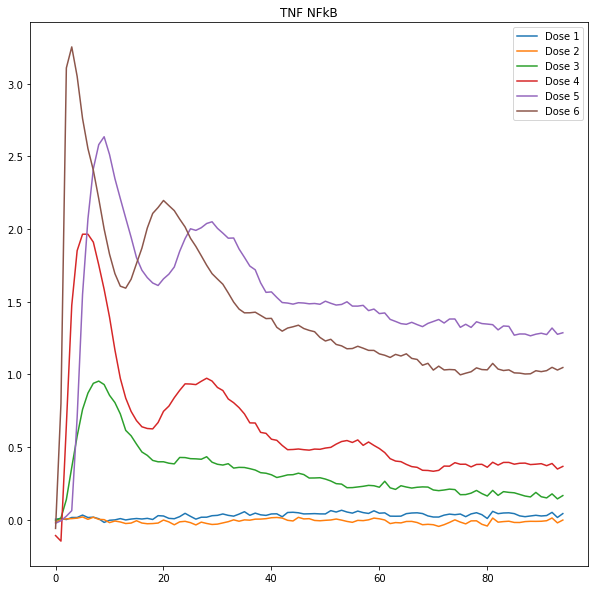

In [86]:
visualize_trajectories(tnf_nfkb_testset, title='TNF NFkB', dim=1)

6


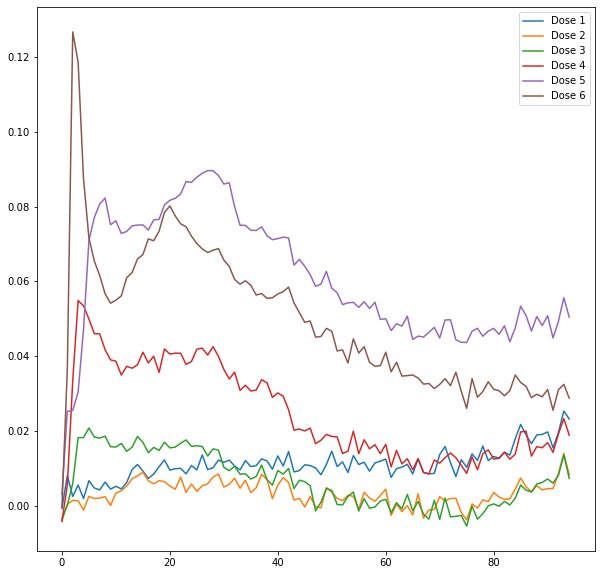

In [14]:
visualize_trajectories(testset_tnf_1d)

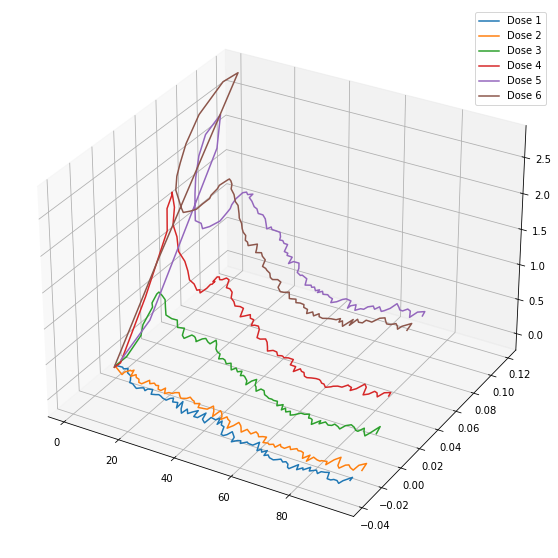

In [15]:
visualize_trajectories(testset_tnf_2d, dim=2)

### 1D NFkB

In [88]:
tnf_nfkb_model = TSC_1(
    input_dim=1,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
tnf_nfkb_model = tnf_nfkb_model.to(device)
tnf_nfkb_optim = torch.optim.Adam(tnf_nfkb_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [89]:
res = train_model(
    model=tnf_nfkb_model,
    optimizer=tnf_nfkb_optim,
    trainloader=tnf_nfkb_trainloader,
    valloader=tnf_nfkb_valloader,
    criterion=criterion,
    device=device,
    save_path='../weights/tnf_nfkb_dosage_best.pth',
    num_epochs=1500,
    dim=1,
    verbose=50
)

Epoch: 0, Train Loss: 1.5694880485534668, Val Loss: 1.488444447517395, Top 1 Acc: 0.3633720874786377, Lowest Val Loss: 1.488444447517395
Epoch: 50, Train Loss: 1.1439627408981323, Val Loss: 1.2292026281356812, Top 1 Acc: 0.5835028886795044, Lowest Val Loss: 1.0336490869522095
Epoch: 100, Train Loss: 1.0053530931472778, Val Loss: 1.1474175453186035, Top 1 Acc: 0.605087161064148, Lowest Val Loss: 0.9974311590194702
Epoch: 150, Train Loss: 0.9079246520996094, Val Loss: 1.152845025062561, Top 1 Acc: 0.6052325963973999, Lowest Val Loss: 0.9974311590194702
Epoch: 200, Train Loss: 0.8197417855262756, Val Loss: 1.2427788972854614, Top 1 Acc: 0.6114098429679871, Lowest Val Loss: 0.9974311590194702
Epoch: 250, Train Loss: 0.7330365777015686, Val Loss: 1.4155540466308594, Top 1 Acc: 0.6114098429679871, Lowest Val Loss: 0.9974311590194702
Epoch: 300, Train Loss: 0.6511743068695068, Val Loss: 1.6399070024490356, Top 1 Acc: 0.6114098429679871, Lowest Val Loss: 0.9974311590194702
Epoch: 350, Train Lo

In [90]:
tnf_nfkb_weights = torch.load('../weights/tnf_nfkb_dosage_best.pth')
tnf_nfkb_model.load_state_dict(tnf_nfkb_weights['weights'])

<All keys matched successfully>

In [91]:
tnf_nfkb_em = get_evaluation_metrics(tnf_nfkb_model, tnf_nfkb_testset, device, target_names, dim=1)

0.5105916727538349
              precision    recall  f1-score   support

      Dose 1       0.36      0.16      0.22       441
      Dose 2       0.51      0.59      0.55       584
      Dose 3       0.41      0.60      0.49       450
      Dose 4       0.47      0.58      0.52       402
      Dose 5       0.55      0.61      0.58       445
      Dose 6       0.97      0.50      0.66       416

    accuracy                           0.51      2738
   macro avg       0.54      0.51      0.50      2738
weighted avg       0.54      0.51      0.50      2738



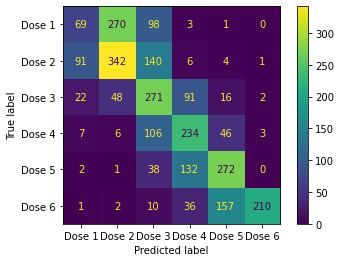

In [92]:
print(tnf_nfkb_em['acc'])
print(tnf_nfkb_em['cr'])
tnf_nfkb_em['cmd'].plot()

### 1D KTR

In [16]:
tnf_model_1d = TSC_1(
    input_dim=1,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
tnf_model_1d = tnf_model_1d.to(device)
tnf_optim_1d = torch.optim.Adam(tnf_model_1d.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [17]:
res = train_model(
    model=tnf_model_1d,
    optimizer=tnf_optim_1d,
    trainloader=trainloader_tnf_1d,
    valloader=valloader_tnf_1d,
    criterion=criterion,
    device=device,
    save_path='../weights/tnf_1d_dosage_best.pth',
    num_epochs=1500,
    dim=1,
    verbose=50
)

Epoch: 0, Train Loss: 1.767087459564209, Val Loss: 1.7674052715301514, Top 1 Acc: 0.2068452388048172, Lowest Val Loss: 1.7674052715301514
Epoch: 50, Train Loss: 1.729926347732544, Val Loss: 1.7543002367019653, Top 1 Acc: 0.2366071492433548, Lowest Val Loss: 1.7211096286773682
Epoch: 100, Train Loss: 1.7281416654586792, Val Loss: 1.7507531642913818, Top 1 Acc: 0.2522321343421936, Lowest Val Loss: 1.7109534740447998
Epoch: 150, Train Loss: 1.6806777715682983, Val Loss: 1.6966936588287354, Top 1 Acc: 0.3980654776096344, Lowest Val Loss: 1.4112751483917236
Epoch: 200, Train Loss: 1.6201332807540894, Val Loss: 1.6335523128509521, Top 1 Acc: 0.43467265367507935, Lowest Val Loss: 1.3827991485595703
Epoch: 250, Train Loss: 1.57693612575531, Val Loss: 1.5961785316467285, Top 1 Acc: 0.43467265367507935, Lowest Val Loss: 1.382117748260498
Epoch: 300, Train Loss: 1.5363295078277588, Val Loss: 1.568629264831543, Top 1 Acc: 0.44360119104385376, Lowest Val Loss: 1.3781530857086182
Epoch: 350, Train L

In [20]:
tnf_model_1d_weights = torch.load('../weights/tnf_1d_dosage_best.pth')
tnf_model_1d.load_state_dict(tnf_model_1d_weights['weights'])

<All keys matched successfully>

In [21]:
tnf_em_1d = get_evaluation_metrics(tnf_model_1d, testset_tnf_1d, device, target_names, dim=1)

0.27736958119030125
              precision    recall  f1-score   support

      Dose 1       0.27      0.06      0.10       438
      Dose 2       0.36      0.24      0.29       579
      Dose 3       0.21      0.42      0.28       447
      Dose 4       0.23      0.41      0.30       402
      Dose 5       0.15      0.14      0.15       443
      Dose 6       0.68      0.43      0.53       413

    accuracy                           0.28      2722
   macro avg       0.32      0.28      0.27      2722
weighted avg       0.32      0.28      0.27      2722



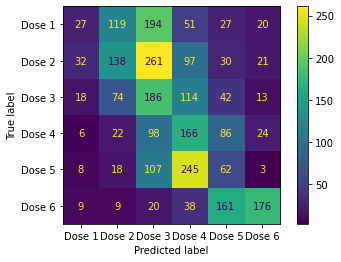

In [22]:
print(tnf_em_1d['acc'])
print(tnf_em_1d['cr'])
tnf_em_1d['cmd'].plot()

## 2D

In [23]:
tnf_model_2d = TSC_1(
    input_dim=2,
    hidden_dim=95,
    output_dim=6,
    num_layers=2,
    linear_hidden_dim=256
)

device = torch.device('cuda:0')
tnf_model_2d = tnf_model_2d.to(device)
tnf_optim_2d = torch.optim.Adam(tnf_model_2d.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

res = train_model(
    model=tnf_model_2d,
    optimizer=tnf_optim_2d,
    trainloader=trainloader_tnf_2d,
    valloader=valloader_tnf_2d,
    criterion=criterion,
    device=device,
    save_path='../weights/tnf_2d_dosage_best.pth',
    num_epochs=750,
    dim=2,
    verbose=50
)

Epoch: 0, Train Loss: 1.5796890258789062, Val Loss: 1.425694465637207, Top 1 Acc: 0.41279762983322144, Lowest Val Loss: 1.425694465637207
Epoch: 50, Train Loss: 1.2517927885055542, Val Loss: 1.2509454488754272, Top 1 Acc: 0.5465773344039917, Lowest Val Loss: 1.0822432041168213
Epoch: 100, Train Loss: 1.0955106019973755, Val Loss: 1.1151541471481323, Top 1 Acc: 0.6571428775787354, Lowest Val Loss: 0.8487019538879395
Epoch: 150, Train Loss: 0.9670858979225159, Val Loss: 1.0437813997268677, Top 1 Acc: 0.6898809671401978, Lowest Val Loss: 0.8202878832817078
Epoch: 200, Train Loss: 0.8587649464607239, Val Loss: 1.0676782131195068, Top 1 Acc: 0.6900297403335571, Lowest Val Loss: 0.8202878832817078
Epoch: 250, Train Loss: 0.75543212890625, Val Loss: 1.2027573585510254, Top 1 Acc: 0.6900297403335571, Lowest Val Loss: 0.8202878832817078
Epoch: 300, Train Loss: 0.6560823321342468, Val Loss: 1.432185411453247, Top 1 Acc: 0.6900297403335571, Lowest Val Loss: 0.8202878832817078
Epoch: 350, Train Lo

In [24]:
tnf_model_2d_weights = torch.load('../weights/tnf_2d_dosage_best.pth')
tnf_model_2d.load_state_dict(tnf_model_2d_weights['weights'])

<All keys matched successfully>

In [26]:
tnf_em_2d = get_evaluation_metrics(tnf_model_2d, testset_tnf_2d, device, target_names, dim=2)

0.6914572864321608
              precision    recall  f1-score   support

      Dose 1       0.48      0.52      0.50       294
      Dose 2       0.57      0.47      0.52       399
      Dose 3       0.63      0.70      0.66       574
      Dose 4       0.73      0.68      0.70       548
      Dose 5       0.72      0.82      0.76       549
      Dose 6       0.89      0.81      0.85       621

    accuracy                           0.69      2985
   macro avg       0.67      0.67      0.67      2985
weighted avg       0.70      0.69      0.69      2985



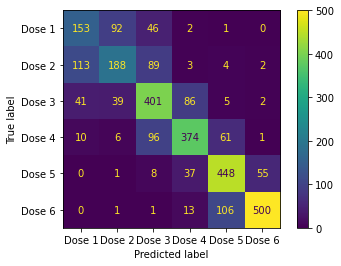

In [27]:
print(tnf_em_2d['acc'])
print(tnf_em_2d['cr'])
tnf_em_2d['cmd'].plot()

In [ ]:
tnf_train_path_2d = [[i, j] for i,j in zip(os.listdir(path)[36:42], os.listdir(path)[84:90])]
tnf_test_path_2d = [[i, j] for i,j in zip(os.listdir(path)[42:48], os.listdir(path)[90:96])]

trainloader_tnf_1d, valloader_tnf_1d, testset_tnf_1d = prep_dosage_analysis(path, tnf_train_path_1d, tnf_test_path_1d, dim=1)
trainloader_tnf_2d, valloader_tnf_2d, testset_tnf_2d = prep_dosage_analysis(path, tnf_train_path_2d, tnf_test_path_2d, dim=2)